In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as kr

Importing the MNIST data...

In [5]:
(X_train, y_train), (X_test, y_test) =  kr.datasets.fashion_mnist.load_data()

In [10]:
X_train.shape[0]

60000

In [12]:
X_test.shape[0]

10000

Creating subtrain validation splits...

In [13]:
X_valid, X_subtrain = X_train[:10000], X_train[10000:]
y_valid, y_subtrain = y_train[:10000], y_train[10000:]

In [34]:
train_set = tf.data.Dataset.from_tensor_slices((X_subtrain, y_subtrain)).shuffle(len(X_subtrain))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Defining labels and image features of protobuf...

In [44]:
def serialize_example(image, label):

  image_serial = tf.io.serialize_tensor(image)
  feature={
            "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_serial.numpy()])),
            "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label.numpy()])),
          }

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [45]:
for image, label in valid_set.take(1):
    print(serialize_example(image, label))

b'\n\xc2\x06\n\xaf\x06\n\x05image\x12\xa5\x06\n\xa2\x06\n\x9f\x06\x08\x04\x12\x08\x12\x02\x08\x1c\x12\x02\x08\x1c"\x90\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\rI\x00\x00\x01\x04\x00\x00\x00\x00\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x00$\x88\x7f>6\x00\x00\x00\x01\x03\x04\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x06\x00f\xcc\xb0\x86\x90{\x17\x00\x00\x00\x00\x0c\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9b\xec\xcf\xb2k\x9c\xa1m@\x17M\x82H\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00E\xcf\xdf\xda\xd8\xd8\xa3\x7fyz\x92\x8dX\xacB\x00\x00\x00\x00\x00\x00\x00\x00\x

Writing TFRecord to disk...

In [47]:
def tf_serialize_example(image, label):
  tf_string = tf.py_function(
    serialize_example, (image, label), tf.string)     
  return tf.reshape(tf_string, ()) 

In [49]:
serialized_train = train_set.map(tf_serialize_example)
serialized_train

<MapDataset shapes: (), types: tf.string>

In [52]:
def train_generator():
  for features in train_set:
    yield serialize_example(*features)

In [55]:
def valid_generator():
  for features in valid_set:
    yield serialize_example(*features)

In [56]:
def test_generator():
  for features in test_set:
    yield serialize_example(*features)

In [53]:
serialized_train_dataset = tf.data.Dataset.from_generator(
    train_generator, output_types=tf.string, output_shapes=())

In [54]:
serialized_train_dataset

<FlatMapDataset shapes: (), types: tf.string>

In [57]:
serialized_valid_dataset = tf.data.Dataset.from_generator(
    valid_generator, output_types=tf.string, output_shapes=())

In [58]:
serialized_test_dataset = tf.data.Dataset.from_generator(
    test_generator, output_types=tf.string, output_shapes=())

In [6]:
PATH = "D:/Program Files (x86)/Jupyter Projects/"
def write_tfrecord(name, dataset):
    filepath = PATH + name
    writer = tf.data.experimental.TFRecordWriter(filepath)
    writer.write(dataset)
    return filepath

In [60]:
train_tfrecord_path = write_tfrecord("mnist_train.tfrecord", serialized_train_dataset)

Instructions for updating:
To write TFRecords to disk, use `tf.io.TFRecordWriter`. To save and load the contents of a dataset, use `tf.data.experimental.save` and `tf.data.experimental.load`


In [61]:
raw_dataset = tf.data.TFRecordDataset(train_tfrecord_path)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [63]:
valid_tfrecord_path = write_tfrecord("mnist_valid.tfrecord", serialized_valid_dataset)
test_tfrecord_path = write_tfrecord("mnist_test.tfrecord", serialized_test_dataset)

Reading TFRecord from disk...

In [2]:
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'label': tf.io.FixedLenFeature([], tf.int64, default_value=0)
}

def parse_function(tfrecord):
  return tf.io.parse_single_example(tfrecord, feature_description)

In [68]:
parsed_dataset = raw_dataset.map(parse_function)
parsed_dataset

<MapDataset shapes: {image: (), label: ()}, types: {image: tf.string, label: tf.int64}>

In [3]:
def preprocess_function(tfrecord):
  example = parse_function(tfrecord)
  image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
  image = tf.reshape(image, shape=[28, 28])
  return image, example["label"]

In [4]:
def tfrecords_reader_dataset(filepaths,
 n_read_threads=5, shuffle_buffer_size=None,
 n_parse_threads=5, batch_size=32):
    
 dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
 if shuffle_buffer_size:
    dataset = dataset.shuffle(shuffle_buffer_size) 
 dataset = dataset.map(preprocess_function, num_parallel_calls=n_parse_threads)
 return dataset.batch(batch_size).prefetch(1)

In [7]:
train_tfrecord_path = PATH + "mnist_train.tfrecord"

In [8]:
new_train_set = tfrecords_reader_dataset(train_tfrecord_path, shuffle_buffer_size=60000)

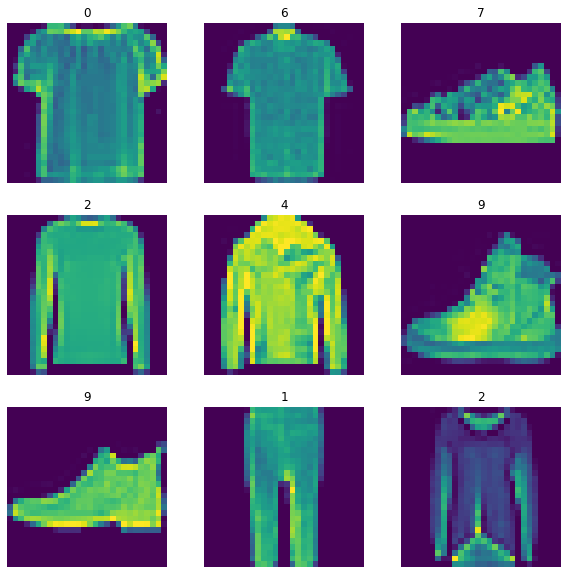

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in new_train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(labels[i].numpy())
    plt.axis("off")

In [9]:
valid_tfrecord_path = PATH + "mnist_valid.tfrecord"
test_tfrecord_path = PATH + "mnist_test.tfrecord"

In [11]:
new_valid_set = tfrecords_reader_dataset(valid_tfrecord_path)
new_test_set = tfrecords_reader_dataset(test_tfrecord_path)

Building regular ANN...

In [12]:
model = kr.models.Sequential([
    kr.layers.experimental.preprocessing.Rescaling(1./255),
    kr.layers.Flatten(),
    kr.layers.Dense(128, activation="relu"),
    kr.layers.Dense(128, activation="relu"),
    kr.layers.Dense(10, activation="softmax")
])

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [14]:
history = model.fit(new_train_set, epochs=10, validation_data=new_valid_set)

Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.4940 - accuracy: 0.8226 - val_loss: 0.4581 - val_accuracy: 0.8255
Epoch 2/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.3608 - accuracy: 0.8679 - val_loss: 0.3671 - val_accuracy: 0.8606
Epoch 3/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.3252 - accuracy: 0.8800 - val_loss: 0.3308 - val_accuracy: 0.8784
Epoch 4/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.3026 - accuracy: 0.8882 - val_loss: 0.3181 - val_accuracy: 0.8859
Epoch 5/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2851 - accuracy: 0.8954 - val_loss: 0.3104 - val_accuracy: 0.8862
Epoch 6/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2721 - accuracy: 0.8983 - val_loss: 0.3112 - val_accuracy: 0.8896
Epoch 7/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2590 - accuracy: 0.9023 - val_loss: 0.3216 - val_accuracy:

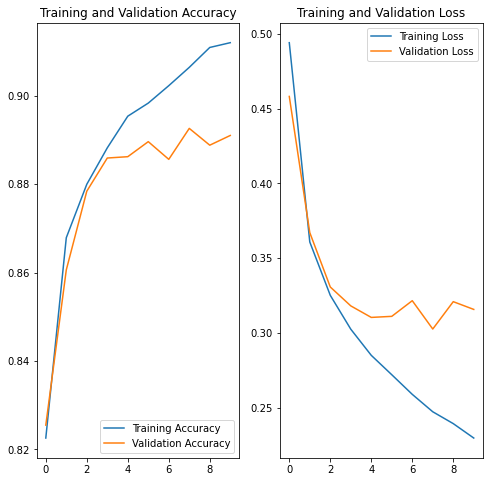

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Building CNN...

In [28]:
model2 = tf.keras.models.Sequential([
 tf.keras.layers.Conv2D(128, 7, activation="relu", padding="same",
 input_shape=[28, 28, 1]),
 tf.keras.layers.MaxPooling2D(2),
 tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
 tf.keras.layers.MaxPooling2D(2),
 tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same"),
 tf.keras.layers.MaxPooling2D(2),
 tf.keras.layers.Flatten(),
 tf.keras.layers.Dense(128, activation="relu"),
 tf.keras.layers.Dropout(0.5),
 tf.keras.layers.Dense(128, activation="relu"),
 tf.keras.layers.Dropout(0.5),
 tf.keras.layers.Dense(10, activation="softmax")
])


In [29]:
model2.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [30]:
history2 = model.fit(new_train_set, epochs=10, validation_data=new_valid_set)

Epoch 1/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0873 - accuracy: 0.9665 - val_loss: 0.5194 - val_accuracy: 0.8945
Epoch 2/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0872 - accuracy: 0.9677 - val_loss: 0.5610 - val_accuracy: 0.8980
Epoch 3/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0851 - accuracy: 0.9672 - val_loss: 0.5728 - val_accuracy: 0.8954
Epoch 4/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0839 - accuracy: 0.9686 - val_loss: 0.5494 - val_accuracy: 0.9002
Epoch 5/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0807 - accuracy: 0.9691 - val_loss: 0.5867 - val_accuracy: 0.8946
Epoch 6/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0798 - accuracy: 0.9693 - val_loss: 0.6128 - val_accuracy: 0.8935
Epoch 7/10
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0763 - accuracy: 0.9707 - val_loss: 0.6622 - val_accuracy: